## Test Kinematic Inconsistency
Questo blocco di codice iniziale serve come piattaforma di configurazione e caricamento per la valutazione dell'efficacia del modello LSTM Autoencoder nel rilevare attacchi cinematici.

1. **Preparazione degli Strumenti Analitici e di Misurazione.**
    Il codice importa un set di librerie focalizzate sulla valutazione della performance dove troviamo le metriche standard di machine learning.

2. **Ottimizzazione e Caricamento dei Componenti.**
   Viene eseguita l'ottimizzazione dell'hardware (GPU e Mixed Precision) per garantire che la fase di test sia rapida ed efficiente.
   
3. **Definizione del Contesto Operativo.**
   Vengono riconfermati i parametri strutturali del modello (WINDOW_SIZE, BATCH_SIZE e le quattro feature dinamiche) e, crucialmente, viene identificato il set di File di Test.  
   
   Questi file sono la base sperimentale. Su queste traiettorie originali (mai viste dal modello), verrà iniettato l'attacco cinematico. Il modello, che è stato addestrato solo sulla normalità, elaborerà queste traiettorie alterate.

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import tensorflow as tf
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError as e:
        print(e)

#PATH
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset' 
SCALER_PATH = 'scaler.joblib' 
MODEL_PATH = 'lstm_autoencoder_best.keras' 

COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
WINDOW_SIZE = 30  
BATCH_SIZE = 64 

#File di Test
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]
print(f"File di Test caricati")

2025-11-21 17:13:18.821802: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 17:13:18.867105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 17:13:19.979051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU e Mixed Precision Attivate.
File di Test caricati


#####  Definizione delle Funzioni del Data Generator
Questo blocco definisce le due funzioni essenziali per trasformare i dati grezzi in sequenze pronte per il modello, mantenendo un'alta efficienza in termini di memoria (RAM)

In [3]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


#### Caricamento Risorse

In [4]:
# Carica Scaler e Modello
scaler = joblib.load(SCALER_PATH)
model = tf.keras.models.load_model(MODEL_PATH)
print("Modello e Scaler caricati.")

# Inizializza il generatore pulito
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

I0000 00:00:1763741603.347982   16104 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2995 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello e Scaler caricati.


#### Funzione di Attacco Cinematico
La funzione `apply_kinematic_attack `prende un batch di traiettorie normali e introduce un'anomalia istantanea, creando un'incoerenza fisica tra la posizione dichiarata e i parametri di movimento dinamico della nave.
Un attacco cinematico simula un errore o una manipolazione nel segnale GPS/AIS (Automatic Identification System) della nave. L'attacco non modifica la rotta o la velocità in modo graduale e realistico, ma introduce una discontinuità istantanea nella posizione. Il modello LSTM Autoencoder è stato addestrato per apprendere proprio questa relazione fisica coerente. Quando la rete vede una posizione che "salta" senza che la velocità e la rotta cambino in modo corrispondente, l'errore di ricostruzione sarà altissimo.
La funzione crea l'attacco agendo direttamente sui dati normalizzati:

1. **Copia e Inizio Attacco:** La funzione crea una copia dei dati puliti `(batch_clean.copy())` per non alterare l'originale. L'attacco viene fatto partire dal timestep 15 `(attack_start_idx)`, ovvero a metà della finestra temporale di 30 step.

2. **Iniezione del Salto di Posizione:**
   * `batch_attacked[:, attack_start_idx:, 0] += shift_magnitude`(Latitudine) 
   * `batch_attacked[:, attack_start_idx:, 1] += shift_magnitude` (Longitudine)
      * Questo è il cuore dell'attacco: Viene aggiunto un offset costante `shift_magnitude` a tutti i punti successivi al timestep 15. Questo crea un **"gradino"** istantaneo nel segnale della posizione, simulando un teletrasporto della nave.

3. **Incoerenza Vettoriale:** La parte cruciale dell'attacco è che i parametri dinamici (Velocità $\text{SOG}$ e Rotta $\text{COG}$, indici 2 e 3) non vengono modificati.

L'output della funzione è un batch di traiettorie che mostrano: posizione saltata $\cap$ dinamica inspiegabilmente coerente, creando esattamente l'anomalia che il modello LSTM è stato addestrato a riconoscere.

In [5]:
def apply_kinematic_attack(batch_clean, attack_start_idx=15, shift_magnitude=2.0):

    #batch_clean: Batch di dati normalizzati
    #attack_start_idx: A quale step inizia l'attacco (15 è metà finestra)
    #shift_magnitude: Di quanto spostare (in deviazioni standard)
    
    batch_attacked = batch_clean.copy()
    
    # Aggiungiamo un offset costante (simuliamo un salto istantaneo)
    # Questo crea un "gradino" impossibile nella posizione
    batch_attacked[:, attack_start_idx:, 0] += shift_magnitude # Sposta Lat
    batch_attacked[:, attack_start_idx:, 1] += shift_magnitude # Sposta Lon
    
    # non modifichiamo SOG e COG (indici 2 e 3). 
    # È qui l'incoerenza perchè la posizione cambia, ma la velocità non lo giustifica.
    
    return batch_attacked
print("Funzione di attacco definita.")

Funzione di attacco definita.


#### Creazione del dataset misto
E' stato scelto di attaccare metà dataset.

In [6]:
# Creiamo il dataset misto
X_test_mixed = []
y_true = [] # 0 = Normale, 1 = Attacco

# Prendiamo NUM_BATCHES batch dal generatore
NUM_BATCHES = 10000

for _ in range(NUM_BATCHES):
    #Prendi dati puliti
    clean_batch, _ = next(test_gen)
    
    #Crea la versione attaccata
    attacked_batch = apply_kinematic_attack(clean_batch, shift_magnitude=3.0) # Attacco forte
    
    #Aggiungi alla lista
    #Aggiungiamo metà puliti
    half = len(clean_batch) // 2
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half) # Etichetta 0
    
    #Aggiungiamo metà attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half)) #Etichetta 1

# Concateniamo tutto in un unico array numpy
X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Campioni Normali: {np.sum(y_true == 0)}")
print(f"Campioni Attaccati: {np.sum(y_true == 1)}")

Dataset creato: (640000, 30, 4)
Campioni Normali: 320000
Campioni Attaccati: 320000


#### Calcolo degli Errori di Rilevamento
Si sottopone il modello addestrato ai dati contenenti l'attacco cinematico. Come metrica chiave calcoliamo il $\text{MAE}$


In [7]:
print("Esecuzione predizioni sul dataset misto...")
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcoliamo l'errore MAE 
mae_per_sample = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))

print(f"Calcolo errori completato")

Esecuzione predizioni sul dataset misto...
   16/20000 ━━━━━━━━━━━━━━━━━━━━ 1:07 3ms/step     

2025-11-21 17:13:32.558034: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-11-21 17:13:32.581595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step
Calcolo errori completato


#### Istogramma comparativo
Il codice genera un doppio istogramma che confronta le firme d'errore del modello quando elabora dati puliti e quando elabora dati compromessi.

**Analisi dell'Output Grafico:** Il grafico "Distribuzione Errore di Ricostruzione: Normali vs Attacchi"  è la prova tangibile del successo del rilevatore:
  * **Distribuzione delle Traiettorie Normali (Verde):** La curva verde è estremamente concentrata vicino allo zero ($\text{MAE} < 0.1$). Il picco principale si trova intorno allo $0.03$. Questo conferma che il modello LSTM Autoencoder ricostruisce le traiettorie normali con un errore quasi nullo. Questa è la baseline di normalità.
  * **Distribuzione delle Traiettorie Attaccate (Rosso):** La curva rossa è completamente separata dalla distribuzione normale. Inizia solo dopo $\text{MAE} \approx 0.7$. Il picco della distribuzione degli attacchi si trova tra $\text{MAE} \approx 0.8$ e $1.0$.L'enorme errore di ricostruzione (da 20 a 30 volte superiore alla media normale) dimostra che l'incoerenza fisica introdotta dall'attacco cinematico ha distrutto la capacità del modello di ricostruire la sequenza. Il modello ha "capito" che la traiettoria è fisicamente impossibile.

La totale separazione tra le due distribuzioni è il risultato ottimale per un sistema di rilevamento. Questo significa che qualsiasi soglia scelta tra $\text{MAE} = 0.2$ e $\text{MAE} = 0.7$ (ad esempio, $\text{Soglia}=0.4$) è sufficiente per separare perfettamente le traiettorie normali da quelle attaccate. Il modello ha un'alta differenziabilità tra le classi, rendendo il rilevamento altamente accurato e robusto.


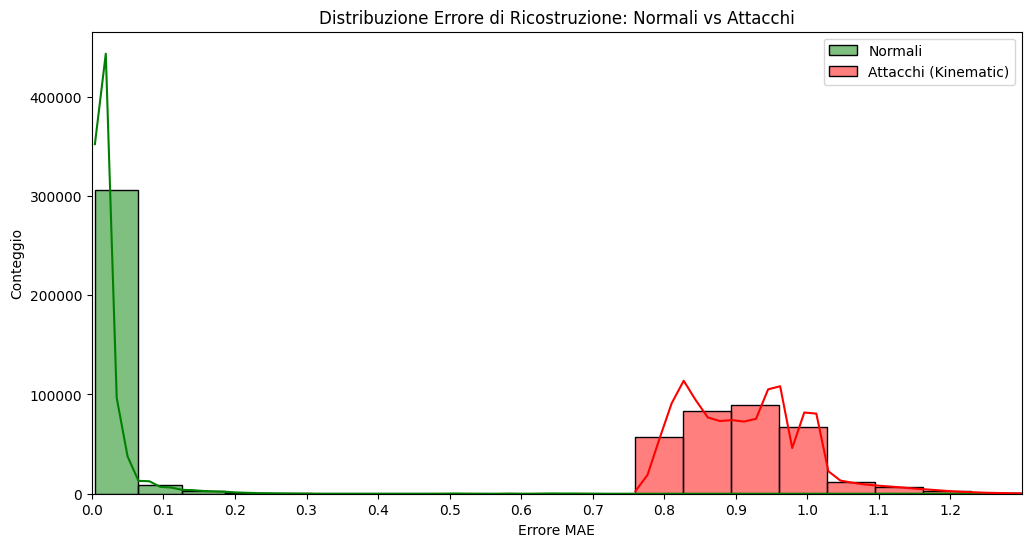

In [8]:
plt.figure(figsize=(12, 6))

# Istogramma Normali (Verde)
sns.histplot(mae_per_sample[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.5)

# Istogramma Attacchi (Rosso)
sns.histplot(mae_per_sample[y_true == 1], color='red', label='Attacchi (Kinematic)', kde=True, bins=50, alpha=0.5)

plt.xlim(0, 1.3)
plt.xticks(np.arange(0, 1.3, 0.1))
#plt.xticks(np.arange(0, 1.6, 0.05), rotation=45)

plt.title("Distribuzione Errore di Ricostruzione: Normali vs Attacchi")
plt.xlabel("Errore MAE")
plt.ylabel("Conteggio")
plt.legend()
plt.show()

#### Valutazione Quantitativa e Matrice di Confusione
1. **Definizione Statistica della Soglia**
    * Logica: La soglia di rilevamento **(THRESHOLD)** è definita statisticamente utilizzando gli errori di ricostruzione delle sole   traiettorie normali.
    * **Regola del $3\sigma$:** Si utilizza la regola della deviazione standard ($\mathbf{3\sigma}$), comune nei sistemi di rilevamento anomalie. La soglia viene impostata alla Media degli Errori Normali più tre volte la Deviazione Standard di tali errori.

Il **TRESHOLD** è di $\mathbf{0.1385}$, che è molto più basso del $\text{MAE}$ degli attacchi (che partiva da circa $0.7$), garantendo un'ottima separazione.

2. **Classificazione e Calcolo delle Metriche**
   * Viene eseguita la classificazione binaria: se l'errore $\text{MAE}$ del campione supera la **THRESHOLD**, il sistema predice un Attacco (1); altrimenti, predice Normale (0).
   * **Metriche Calcolate:** 
     * $\mathbf{Accuracy} \approx 0.9937$ (99.37% di tutte le classificazioni sono corrette).
     * $\mathbf{Precision} \approx 0.9875$ (Quando il modello dice "Attacco", ha ragione nel 98.75% dei casi).
     * $\mathbf{Recall} = 1.0000$ (Il modello ha trovato il 100% di tutti gli attacchi reali presenti nel set).
     * $\mathbf{F1-Score} \approx 0.9937$ (La media armonica di Precision e Recall, un ottimo indicatore della performance complessiva).

3. **Analisi della Matrice di Confusione**
   * **True Positives (320,000):** Il modello ha identificato correttamente tutti i campioni che contenevano l'attacco cinematico.
   * **True Negatives (315,939):** Il modello ha classificato correttamente la stragrande maggioranza dei campioni normali.
   * **False Negatives (0):** Non c'è stato nessun falso negativo. 
   * **False Positives (4,061):** Ci sono stati 4,061 falsi positivi (traiettorie normali classificate erroneamente come attacco). Questo corrisponde allo $\mathbf{0.63\%}$ dei campioni normali, in linea con l'aspettativa statistica di una soglia $3\sigma$ (dove si aspetta che circa lo $0.3\%$ cada fuori).


Soglia rilevamento calcolata (Mean + 3*Std): 0.1385

--- RISULTATI CLASSIFICAZIONE ---
Accuracy:  0.9937
Precision: 0.9875
Recall:    1.0000
F1-Score:  0.9937


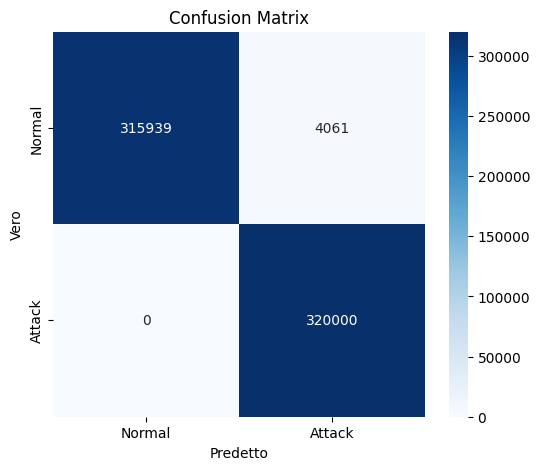

In [ ]:
# Definiamo la soglia (Threshold)
errori_normali = mae_per_sample[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia rilevamento calcolata (Mean + 3*Std): {THRESHOLD:.4f}")

# Classificazione --> Se errore > soglia -> È un attacco (1)
y_pred = (mae_per_sample > THRESHOLD).astype(int)

# Metriche
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- RISULTATI CLASSIFICAZIONE ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix")
plt.ylabel("Vero")
plt.xlabel("Predetto")
plt.show()

#### Visualizzazione di un singolo attacco
Il codice estrae un campione specifico di traiettoria a cui è stato applicato l'attacco cinematico e traccia su un grafico 2D (Latitudine vs Longitudine) sia l'input manipolato che il tentativo del modello di ricostruirlo.
Il grafico "Visualizzazione Attacco Kinematic Inconsistency"  è la prova visiva del fallimento del modello
  * **Input Attaccato:** La traiettoria inizia con un segmento normale, ma poi si osserva un salto netto e istantaneo (il "Teletrasporto") a un'altra coordinata. Questo è l'attacco cinematico che viola le leggi della fisica (un cambio di posizione senza velocità adeguata).
  * **Ricostruzione del Modello**:Il modello non riesce a replicare il salto. Al contrario, quando l'Encoder riceve il salto impossibile, il Decoder tenta di generare una sequenza che sia fisicamente plausibile e simile a quelle viste nel training.Il risultato è una ricostruzione distorta e spezzettata.

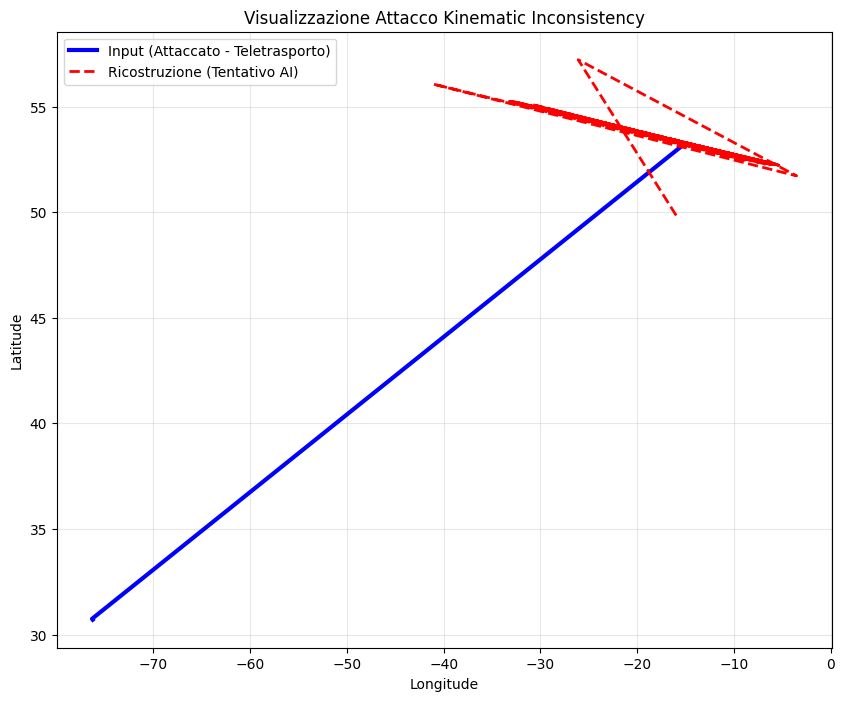

In [10]:
# Troviamo un esempio di attacco rilevato
attack_indices = np.where(y_true == 1)[0]
idx = attack_indices[0] # Il primo attacco

real_input = X_test_mixed[idx] # Questo è quello corrotto
reconstructed = reconstructions[idx] # Questo è quello che la rete ha provato a fare

# Denormalizziamo per il plot 2D
real_phys = scaler.inverse_transform(real_input)
recon_phys = scaler.inverse_transform(reconstructed)

plt.figure(figsize=(10, 8))
plt.plot(real_phys[:, 1], real_phys[:, 0], 'b-', label='Input (Attaccato - Teletrasporto)', linewidth=3)
plt.plot(recon_phys[:, 1], recon_phys[:, 0], 'r--', label='Ricostruzione (Tentativo AI)', linewidth=2)
plt.title("Visualizzazione Attacco Kinematic Inconsistency")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()